# Object Detection Using Custom YOLOv10 Object Detector

Import needed modules

In [32]:
import os
import glob as glob
import matplotlib.pyplot as plt
import cv2
import requests
import random
import numpy as np

np.random.seed(42)

### The dataset is structured in the following manner:

```
├── data.yaml
├── test
│   ├── images
│   └── labels
├── train
│   ├── images
│   └── labels
└── valid
    ├── images
    └── labels

```

### The Dataset YAML File

The dataset YAML (`data.yaml`) file containing the path to the training and validation images and labels is already provided. This file will also contain the class names from the dataset.

The dataset contains number of classes: [ ... ]

The following block shows the contents of the `data.yaml` file.

```yaml
path: ../Cars Detection
train: train/images
val: valid/images

nc: 5
names: ['Ambulance', 'Bus', 'Car', 'Motorcycle', 'Truck']
```

----------------------------------------------------

# Create needed functions

### Function to convert bounding boxes in YOLO format to xmin, ymin, xmax, ymax.

In [33]:
'''The current annotations in the text files are in normalized `[x_center, y_center, width, height]` format.
    Let's write a function that will convert it back to `[x_min, y_min, x_max, y_max]` format to check these annotations'''

def yolo2bbox(bboxes):
    xmin, ymin = bboxes[0]-bboxes[2] / 2, bboxes[1] - bboxes[3] / 2
    xmax, ymax = bboxes[0]+bboxes[2] / 2, bboxes[1] + bboxes[3] / 2
    return xmin, ymin, xmax, ymax

In [34]:
class_names = ['Ambulance', 'Bus', 'Car', 'Motorcycle', 'Truck']
colors = np.random.uniform(0, 255, size=(len(class_names), 3))

def plot_box(image, bboxes, labels):
    # Need the image height and width to denormalize
    # the bounding box coordinates
    h, w, _ = image.shape
    for box_num, box in enumerate(bboxes):
        x1, y1, x2, y2 = yolo2bbox(box)
        
        # denormalize the coordinates
        xmin = int(x1 * w)
        ymin = int(y1 * h)
        xmax = int(x2 * w)
        ymax = int(y2 * h)
        width = xmax - xmin
        height = ymax - ymin
        
        class_name = class_names[int(labels[box_num])]
        
        cv2.rectangle(
            image, 
            (xmin, ymin), (xmax, ymax),
            color=colors[class_names.index(class_name)],
            thickness=2
        ) 

        font_scale = min(1,max(3,int(w/500)))
        font_thickness = min(2, max(10,int(w/50)))
        
        p1, p2 = (int(xmin), int(ymin)), (int(xmax), int(ymax))
        
        # Text width and height
        tw, th = cv2.getTextSize(class_name, 0, fontScale=font_scale, thickness=font_thickness)[0]
        p2 = p1[0] + tw, p1[1] + -th - 10
        cv2.rectangle(
            image, 
            p1, p2,
            color=colors[class_names.index(class_name)],
            thickness=-1,
        )
        cv2.putText(
            image, 
            class_name,
            (xmin+1, ymin-10),
            cv2.FONT_HERSHEY_SIMPLEX,
            font_scale,
            (255, 255, 255),
            font_thickness
        )
    return image

### Function to plot images with the bounding boxes.

In [35]:
# Function to plot images with the bounding boxes.
def plot(image_paths, label_paths, num_samples):
    all_training_images = glob.glob(image_paths)
    all_training_labels = glob.glob(label_paths)
    all_training_images.sort()
    all_training_labels.sort()
    
    num_images = len(all_training_images)
    
    plt.figure(figsize=(15, 12))
    for i in range(num_samples):
        j = random.randint(0,num_images-1)
        image = cv2.imread(all_training_images[j])
        with open(all_training_labels[j], 'r') as f:
            bboxes = []
            labels = []
            label_lines = f.readlines()
            for label_line in label_lines:
                label = label_line[0]
                bbox_string = label_line[2:]
                x_c, y_c, w, h = bbox_string.split(' ')
                x_c = float(x_c)
                y_c = float(y_c)
                w = float(w)
                h = float(h)
                bboxes.append([x_c, y_c, w, h])
                labels.append(label)
        result_image = plot_box(image, bboxes, labels)
        plt.subplot(2, 2, i+1)
        plt.imshow(result_image[:, :, ::-1])
        plt.axis('off')
    plt.subplots_adjust(wspace=0)
    plt.tight_layout()
    plt.show()

### Visualize images sample.

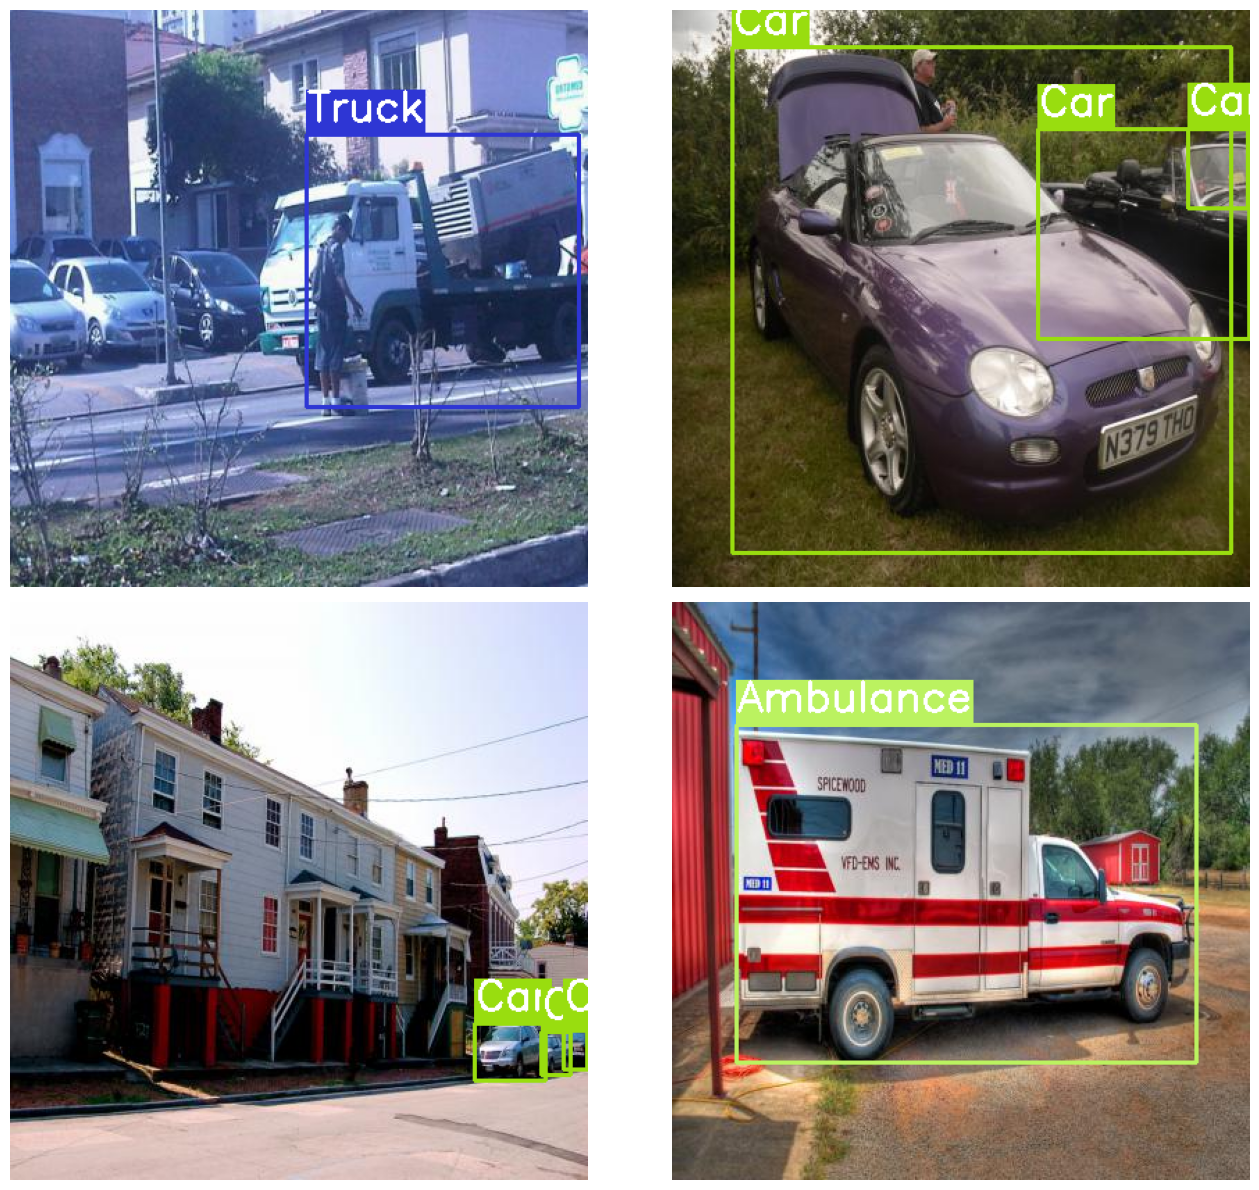

In [36]:
plot(image_paths='/kaggle/input/cars-detection/Cars Detection/train/images/*',
    label_paths='/kaggle/input/cars-detection/Cars Detection/train/labels/*',
    num_samples=4,
)

# YOLOV10

In [37]:
!pip install ultralytics

In [38]:
import os

from ultralytics import YOLO


# Load a model
model = YOLO("yolov10n.yaml")  # build a new model from scratch

In [39]:
# Use the model
results = model.train(data="/kaggle/input/yamlfile/data.yaml", epochs=100)  # train the model

Ultralytics 8.3.152 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/kaggle/input/yamlfile/data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=100, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov10n.yaml, momentum=0.937, mosaic=1.0, multi_scale=False, name=train5, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=100, perspective=0.0, plots=True, pose=12.0, pretrai

train: Scanning /kaggle/input/cars-detection/Cars Detection/train/labels... 878 images, 0 backgrounds, 0 corrupt: 100%|██████████| 878/878 [00:02<00:00, 418.78it/s]

WARNING ⚠️ train: Cache directory /kaggle/input/cars-detection/Cars Detection/train is not writeable, cache not saved.
albumentations: ImageCompression.__init__() got an unexpected keyword argument 'quality_range'


val: Fast image access ✅ (ping: 2.3±0.6 ms, read: 25.7±4.9 MB/s, size: 33.0 KB)


val: Scanning /kaggle/input/cars-detection/Cars Detection/valid/labels... 250 images, 0 backgrounds, 0 corrupt: 100%|██████████| 250/250 [00:00<00:00, 377.65it/s]

WARNING ⚠️ val: Cache directory /kaggle/input/cars-detection/Cars Detection/valid is not writeable, cache not saved.


Plotting labels to runs/detect/train5/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.001111, momentum=0.9) with parameter groups 95 weight(decay=0.0), 108 weight(decay=0.0005), 107 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to runs/detect/train5
Starting training for 100 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/100      2.93G      6.305      13.06      8.475         51        640: 100%|██████████| 55/55 [00:11<00:00,  4.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  5.30it/s]


                   all        250        454    0.00067      0.176   0.000451    0.00018

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      2/100      3.09G      6.195      12.13      8.102         59        640: 100%|██████████| 55/55 [00:10<00:00,  5.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  5.29it/s]


                   all        250        454    0.00168      0.132   0.000899   0.000115

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      3/100       3.1G      5.935      10.99      7.457         54        640: 100%|██████████| 55/55 [00:10<00:00,  5.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  5.05it/s]

                   all        250        454     0.0019       0.36    0.00472    0.00161



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      4/100       3.1G      5.478       9.93      6.868         61        640: 100%|██████████| 55/55 [00:10<00:00,  5.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  5.25it/s]


                   all        250        454    0.00272      0.457     0.0043    0.00117

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      5/100       3.1G      5.195      9.247      6.365         40        640: 100%|██████████| 55/55 [00:10<00:00,  5.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  5.25it/s]


                   all        250        454     0.0031      0.462    0.00758    0.00168

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      6/100       3.1G      4.881      8.797      5.956         48        640: 100%|██████████| 55/55 [00:10<00:00,  5.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  5.17it/s]


                   all        250        454    0.00287      0.561     0.0104    0.00245

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      7/100       3.1G      4.609       8.41      5.666         48        640: 100%|██████████| 55/55 [00:10<00:00,  5.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  5.22it/s]


                   all        250        454    0.00302      0.603    0.00875    0.00231

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      8/100       3.1G       4.45      8.158      5.427         64        640: 100%|██████████| 55/55 [00:10<00:00,  5.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  5.28it/s]


                   all        250        454    0.00324      0.575     0.0184    0.00516

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      9/100       3.1G      4.318       7.96      5.267         28        640: 100%|██████████| 55/55 [00:10<00:00,  5.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  5.12it/s]


                   all        250        454    0.00362      0.692     0.0348     0.0093

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     10/100       3.1G      4.139      7.708      5.042         44        640: 100%|██████████| 55/55 [00:10<00:00,  5.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  5.11it/s]


                   all        250        454     0.0037      0.659      0.014    0.00526

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     11/100       3.1G      3.988      7.483      4.893         69        640: 100%|██████████| 55/55 [00:11<00:00,  4.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  4.82it/s]


                   all        250        454    0.00359      0.678       0.02    0.00736

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     12/100       3.1G      3.923      7.379      4.806         71        640: 100%|██████████| 55/55 [00:11<00:00,  4.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  4.96it/s]


                   all        250        454    0.00412      0.687      0.031     0.0139

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     13/100       3.1G      3.859      7.227      4.704         53        640: 100%|██████████| 55/55 [00:11<00:00,  4.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  4.86it/s]


                   all        250        454    0.00385      0.706     0.0383     0.0142

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     14/100       3.1G      3.764       7.03      4.599         60        640: 100%|██████████| 55/55 [00:11<00:00,  4.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  4.92it/s]


                   all        250        454    0.00436      0.686     0.0469     0.0223

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     15/100       3.1G      3.759      6.942      4.547         52        640: 100%|██████████| 55/55 [00:11<00:00,  4.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  4.74it/s]

                   all        250        454      0.235      0.074     0.0577     0.0337



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     16/100       3.1G      3.582      6.744      4.388         37        640: 100%|██████████| 55/55 [00:10<00:00,  5.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  4.89it/s]


                   all        250        454     0.0573      0.162      0.046     0.0238

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     17/100       3.1G      3.677      6.757      4.431         65        640: 100%|██████████| 55/55 [00:10<00:00,  5.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  4.96it/s]


                   all        250        454      0.659     0.0478     0.0778     0.0415

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     18/100       3.1G      3.625      6.622      4.361         60        640: 100%|██████████| 55/55 [00:10<00:00,  5.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  5.01it/s]


                   all        250        454      0.117      0.093     0.0685     0.0323

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     19/100       3.1G      3.537      6.485      4.301         48        640: 100%|██████████| 55/55 [00:11<00:00,  4.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:03<00:00,  2.12it/s]

                   all        250        454      0.479     0.0973      0.103     0.0553



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     20/100       3.1G      3.525      6.297      4.238         47        640: 100%|██████████| 55/55 [00:12<00:00,  4.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  4.68it/s]


                   all        250        454       0.14      0.145     0.0854     0.0444

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     21/100       3.1G      3.417      6.207      4.126         58        640: 100%|██████████| 55/55 [00:11<00:00,  4.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  5.03it/s]


                   all        250        454      0.245      0.137      0.104     0.0545

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     22/100       3.1G      3.407      6.234      4.176         43        640: 100%|██████████| 55/55 [00:10<00:00,  5.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  4.90it/s]


                   all        250        454      0.279      0.093     0.0776     0.0453

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     23/100       3.1G      3.295      5.992      4.038         51        640: 100%|██████████| 55/55 [00:10<00:00,  5.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  4.83it/s]


                   all        250        454      0.229      0.132      0.101     0.0603

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     24/100       3.1G      3.422      6.065      4.125         33        640: 100%|██████████| 55/55 [00:10<00:00,  5.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  5.09it/s]


                   all        250        454      0.147      0.116      0.117     0.0709

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     25/100       3.1G      3.329      5.921      4.035         50        640: 100%|██████████| 55/55 [00:10<00:00,  5.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  5.00it/s]


                   all        250        454       0.16      0.193      0.123     0.0649

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     26/100       3.1G      3.277      5.803      3.993         58        640: 100%|██████████| 55/55 [00:10<00:00,  5.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  5.19it/s]


                   all        250        454      0.208      0.177      0.125      0.075

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     27/100       3.1G      3.273      5.766      3.966         29        640: 100%|██████████| 55/55 [00:10<00:00,  5.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  5.08it/s]


                   all        250        454      0.198      0.221      0.124     0.0767

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     28/100       3.1G       3.26      5.735          4         82        640: 100%|██████████| 55/55 [00:10<00:00,  5.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  5.05it/s]

                   all        250        454      0.174      0.153      0.122     0.0764



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     29/100       3.1G      3.229       5.74      3.935         60        640: 100%|██████████| 55/55 [00:10<00:00,  5.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  5.20it/s]


                   all        250        454      0.203      0.196       0.13     0.0772

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     30/100       3.1G       3.15      5.614      3.891         49        640: 100%|██████████| 55/55 [00:10<00:00,  5.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  5.16it/s]


                   all        250        454       0.17      0.165      0.122     0.0703

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     31/100       3.1G      3.182      5.541      3.889         43        640: 100%|██████████| 55/55 [00:10<00:00,  5.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  4.85it/s]


                   all        250        454      0.145      0.217      0.139     0.0889

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     32/100       3.1G      3.089      5.513      3.827         31        640: 100%|██████████| 55/55 [00:10<00:00,  5.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  5.01it/s]

                   all        250        454      0.282      0.221       0.16     0.0978



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     33/100       3.1G      3.134      5.392      3.836         59        640: 100%|██████████| 55/55 [00:10<00:00,  5.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  5.17it/s]


                   all        250        454      0.226      0.188       0.17      0.107

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     34/100       3.1G      3.055        5.4      3.782         54        640: 100%|██████████| 55/55 [00:10<00:00,  5.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  5.16it/s]

                   all        250        454      0.212      0.183      0.192      0.126



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     35/100       3.1G          3      5.264      3.755         59        640: 100%|██████████| 55/55 [00:10<00:00,  5.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  5.11it/s]


                   all        250        454      0.214      0.238      0.178      0.117

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     36/100       3.1G      3.011      5.233      3.757         46        640: 100%|██████████| 55/55 [00:10<00:00,  5.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  4.82it/s]


                   all        250        454      0.253       0.29      0.193      0.129

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     37/100       3.1G      3.032      5.128      3.734         47        640: 100%|██████████| 55/55 [00:10<00:00,  5.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  5.06it/s]


                   all        250        454      0.244      0.227      0.186      0.121

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     38/100       3.1G      2.947      5.117      3.687         53        640: 100%|██████████| 55/55 [00:10<00:00,  5.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  4.99it/s]


                   all        250        454      0.213      0.256       0.14       0.09

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     39/100       3.1G      2.982      5.137      3.697         43        640: 100%|██████████| 55/55 [00:10<00:00,  5.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  5.10it/s]


                   all        250        454        0.2      0.263       0.15     0.0985

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     40/100       3.1G      3.004      5.113      3.736         62        640: 100%|██████████| 55/55 [00:10<00:00,  5.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  4.64it/s]

                   all        250        454      0.275      0.259      0.229      0.144



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     41/100       3.1G      2.946      5.065      3.663         55        640: 100%|██████████| 55/55 [00:10<00:00,  5.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  5.16it/s]


                   all        250        454       0.25      0.232      0.222      0.149

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     42/100       3.1G      2.927      4.989      3.666         39        640: 100%|██████████| 55/55 [00:10<00:00,  5.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  5.03it/s]


                   all        250        454      0.364      0.229      0.242      0.164

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     43/100       3.1G      2.865      4.976       3.59         41        640: 100%|██████████| 55/55 [00:10<00:00,  5.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  5.06it/s]


                   all        250        454      0.251      0.282      0.207      0.144

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     44/100       3.1G      2.865      4.917      3.617         53        640: 100%|██████████| 55/55 [00:10<00:00,  5.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  4.94it/s]


                   all        250        454      0.245      0.235       0.22      0.145

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     45/100       3.1G      2.897      4.888      3.612         52        640: 100%|██████████| 55/55 [00:10<00:00,  5.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  4.99it/s]


                   all        250        454      0.267      0.232      0.197      0.132

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     46/100       3.1G      2.855       4.79      3.558         53        640: 100%|██████████| 55/55 [00:10<00:00,  5.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  5.16it/s]


                   all        250        454      0.308      0.281      0.265      0.188

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     47/100       3.1G      2.825       4.71      3.557         49        640: 100%|██████████| 55/55 [00:10<00:00,  5.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  5.06it/s]


                   all        250        454      0.301       0.31      0.254      0.183

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     48/100       3.1G      2.862      4.782      3.584         67        640: 100%|██████████| 55/55 [00:10<00:00,  5.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  5.06it/s]


                   all        250        454      0.248      0.283      0.214      0.149

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     49/100       3.1G      2.848      4.714      3.547         62        640: 100%|██████████| 55/55 [00:10<00:00,  5.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  4.95it/s]


                   all        250        454      0.254      0.292      0.171      0.113

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     50/100       3.1G      2.818      4.664      3.512         55        640: 100%|██████████| 55/55 [00:10<00:00,  5.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  4.95it/s]


                   all        250        454      0.308      0.273      0.255      0.181

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     51/100       3.1G      2.803      4.645      3.538         38        640: 100%|██████████| 55/55 [00:10<00:00,  5.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  5.05it/s]


                   all        250        454      0.323      0.265      0.267       0.19

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     52/100       3.1G      2.774      4.614       3.49         40        640: 100%|██████████| 55/55 [00:10<00:00,  5.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  4.94it/s]

                   all        250        454      0.274      0.318      0.234      0.168



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     53/100       3.1G      2.722       4.62      3.491         41        640: 100%|██████████| 55/55 [00:10<00:00,  5.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  5.11it/s]


                   all        250        454      0.296      0.286      0.257      0.173

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     54/100       3.1G      2.738      4.494      3.471         47        640: 100%|██████████| 55/55 [00:10<00:00,  5.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  4.96it/s]


                   all        250        454      0.353      0.307      0.279      0.199

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     55/100       3.1G      2.742      4.455      3.446         42        640: 100%|██████████| 55/55 [00:10<00:00,  5.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  5.02it/s]

                   all        250        454      0.306      0.324      0.303      0.218



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     56/100       3.1G      2.703       4.44      3.427         58        640: 100%|██████████| 55/55 [00:10<00:00,  5.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  5.03it/s]


                   all        250        454      0.336      0.354      0.284      0.191

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     57/100       3.1G      2.724      4.447      3.429         54        640: 100%|██████████| 55/55 [00:10<00:00,  5.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  4.48it/s]


                   all        250        454       0.36      0.305        0.3      0.213

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     58/100       3.1G      2.657      4.384      3.416         50        640: 100%|██████████| 55/55 [00:10<00:00,  5.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  4.87it/s]


                   all        250        454      0.291      0.332      0.286      0.195

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     59/100       3.1G       2.66       4.28      3.384         83        640: 100%|██████████| 55/55 [00:10<00:00,  5.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  5.04it/s]


                   all        250        454      0.346      0.377      0.318       0.22

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     60/100       3.1G      2.604      4.192      3.346         47        640: 100%|██████████| 55/55 [00:10<00:00,  5.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  4.87it/s]


                   all        250        454      0.412      0.276      0.296      0.217

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     61/100       3.1G      2.643      4.226      3.375         47        640: 100%|██████████| 55/55 [00:10<00:00,  5.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  5.11it/s]

                   all        250        454      0.346      0.344      0.326      0.241



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     62/100       3.1G      2.662      4.271      3.349         31        640: 100%|██████████| 55/55 [00:10<00:00,  5.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  4.91it/s]


                   all        250        454      0.286      0.348      0.261      0.191

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     63/100       3.1G      2.631      4.159      3.371         41        640: 100%|██████████| 55/55 [00:10<00:00,  5.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  5.00it/s]

                   all        250        454      0.366      0.343      0.299       0.21



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     64/100       3.1G      2.697      4.237      3.381         60        640: 100%|██████████| 55/55 [00:10<00:00,  5.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  5.15it/s]


                   all        250        454      0.337      0.353      0.305      0.226

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     65/100       3.1G      2.589      4.075      3.316         54        640: 100%|██████████| 55/55 [00:10<00:00,  5.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  4.97it/s]

                   all        250        454      0.316       0.37      0.343      0.252



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     66/100       3.1G      2.595      4.154       3.32         51        640: 100%|██████████| 55/55 [00:10<00:00,  5.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  4.88it/s]


                   all        250        454      0.433      0.363      0.357      0.256

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     67/100       3.1G      2.607      4.147      3.356         40        640: 100%|██████████| 55/55 [00:10<00:00,  5.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  5.13it/s]

                   all        250        454      0.449      0.335      0.337      0.254



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     68/100       3.1G       2.55      4.015      3.281         53        640: 100%|██████████| 55/55 [00:10<00:00,  5.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  5.28it/s]

                   all        250        454       0.36      0.316      0.331      0.241



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     69/100       3.1G      2.575       4.03      3.298         60        640: 100%|██████████| 55/55 [00:10<00:00,  5.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  5.20it/s]

                   all        250        454      0.444      0.363      0.366      0.269



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     70/100       3.1G       2.54      3.955      3.276         50        640: 100%|██████████| 55/55 [00:10<00:00,  5.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  4.69it/s]

                   all        250        454      0.378      0.404      0.344      0.245



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     71/100       3.1G      2.527      3.965      3.259         50        640: 100%|██████████| 55/55 [00:10<00:00,  5.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  5.08it/s]


                   all        250        454      0.379      0.359      0.335      0.251

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     72/100       3.1G      2.475      3.922      3.232         44        640: 100%|██████████| 55/55 [00:10<00:00,  5.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  5.07it/s]

                   all        250        454      0.444      0.375      0.344      0.254



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     73/100       3.1G      2.539      3.901      3.251         49        640: 100%|██████████| 55/55 [00:10<00:00,  5.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  5.10it/s]


                   all        250        454      0.351      0.366      0.353      0.265

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     74/100       3.1G      2.491       3.98      3.251         41        640: 100%|██████████| 55/55 [00:10<00:00,  5.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  5.13it/s]

                   all        250        454      0.382      0.365       0.36       0.26



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     75/100       3.1G      2.435      3.824      3.203         51        640: 100%|██████████| 55/55 [00:10<00:00,  5.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  4.83it/s]


                   all        250        454      0.427      0.344      0.315      0.234

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     76/100       3.1G      2.467      3.843      3.228         40        640: 100%|██████████| 55/55 [00:10<00:00,  5.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  4.89it/s]

                   all        250        454      0.336      0.371      0.373       0.26



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     77/100       3.1G      2.464      3.839      3.229         46        640: 100%|██████████| 55/55 [00:10<00:00,  5.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  5.13it/s]


                   all        250        454       0.45      0.394       0.39      0.278

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     78/100       3.1G       2.48      3.784      3.214         39        640: 100%|██████████| 55/55 [00:10<00:00,  5.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  4.80it/s]


                   all        250        454      0.387      0.371      0.344      0.256

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     79/100       3.1G      2.412      3.806       3.21         58        640: 100%|██████████| 55/55 [00:10<00:00,  5.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  5.05it/s]

                   all        250        454      0.444      0.389      0.393      0.297



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     80/100       3.1G      2.419      3.708      3.187         48        640: 100%|██████████| 55/55 [00:10<00:00,  5.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  5.08it/s]


                   all        250        454      0.442      0.348      0.353      0.255

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     81/100       3.1G      2.399      3.693      3.166         47        640: 100%|██████████| 55/55 [00:10<00:00,  5.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  4.89it/s]


                   all        250        454      0.499      0.351      0.388      0.285

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     82/100       3.1G      2.442      3.702      3.176         50        640: 100%|██████████| 55/55 [00:10<00:00,  5.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  5.04it/s]


                   all        250        454      0.568       0.36      0.405      0.293

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     83/100       3.1G      2.388      3.632      3.132         57        640: 100%|██████████| 55/55 [00:10<00:00,  5.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  4.83it/s]


                   all        250        454      0.534      0.346      0.407      0.293

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     84/100       3.1G      2.424      3.721      3.187         54        640: 100%|██████████| 55/55 [00:10<00:00,  5.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  4.96it/s]

                   all        250        454      0.475      0.386      0.399      0.291



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     85/100       3.1G      2.363       3.59      3.109         52        640: 100%|██████████| 55/55 [00:10<00:00,  5.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  5.12it/s]

                   all        250        454       0.45      0.386      0.413      0.299



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     86/100       3.1G      2.402       3.62      3.147         53        640: 100%|██████████| 55/55 [00:10<00:00,  5.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  5.17it/s]

                   all        250        454      0.416      0.404       0.41      0.299



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     87/100       3.1G      2.365      3.611      3.109         58        640: 100%|██████████| 55/55 [00:10<00:00,  5.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  5.00it/s]

                   all        250        454      0.551      0.347      0.404      0.293



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     88/100       3.1G      2.367       3.59      3.129         33        640: 100%|██████████| 55/55 [00:10<00:00,  5.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  5.04it/s]


                   all        250        454      0.489      0.398      0.393      0.289

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     89/100       3.1G      2.326      3.505       3.09         44        640: 100%|██████████| 55/55 [00:10<00:00,  5.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  5.06it/s]


                   all        250        454      0.464      0.421       0.41        0.3

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     90/100       3.1G      2.295      3.491      3.078         40        640: 100%|██████████| 55/55 [00:10<00:00,  5.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  4.92it/s]

                   all        250        454      0.495      0.347      0.388      0.282


Closing dataloader mosaic
albumentations: ImageCompression.__init__() got an unexpected keyword argument 'quality_range'

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     91/100       3.1G      2.165      3.366      3.073         26        640: 100%|██████████| 55/55 [00:11<00:00,  4.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  5.06it/s]


                   all        250        454       0.56      0.388      0.437      0.309

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     92/100       3.1G      2.152      3.174       3.04         20        640: 100%|██████████| 55/55 [00:10<00:00,  5.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  4.99it/s]

                   all        250        454      0.649      0.375      0.436      0.308



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     93/100       3.1G      2.155      3.088      3.044         27        640: 100%|██████████| 55/55 [00:10<00:00,  5.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  5.14it/s]

                   all        250        454      0.523      0.409      0.446      0.318



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     94/100       3.1G      2.087      2.992      3.012         27        640: 100%|██████████| 55/55 [00:10<00:00,  5.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  5.11it/s]

                   all        250        454       0.52      0.393      0.423      0.305



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     95/100       3.1G      2.089      2.975      2.987         22        640: 100%|██████████| 55/55 [00:10<00:00,  5.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  5.13it/s]

                   all        250        454      0.501      0.391      0.422      0.305



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     96/100       3.1G      2.031      2.916      2.945         23        640: 100%|██████████| 55/55 [00:10<00:00,  5.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  5.00it/s]


                   all        250        454      0.501      0.411      0.423      0.312

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     97/100       3.1G      2.014      2.953      2.963         20        640: 100%|██████████| 55/55 [00:10<00:00,  5.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  5.14it/s]

                   all        250        454      0.615      0.367      0.443      0.326



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     98/100       3.1G      2.027      2.908      2.956         28        640: 100%|██████████| 55/55 [00:10<00:00,  5.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  5.02it/s]

                   all        250        454      0.508      0.372      0.416      0.305



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     99/100       3.1G      2.001      2.838      2.952         19        640: 100%|██████████| 55/55 [00:10<00:00,  5.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  5.12it/s]

                   all        250        454       0.55      0.385      0.425      0.309



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    100/100       3.1G       2.02      2.848      2.914         20        640: 100%|██████████| 55/55 [00:10<00:00,  5.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  5.17it/s]

                   all        250        454      0.551      0.398      0.431      0.318



100 epochs completed in 0.346 hours.
Optimizer stripped from runs/detect/train5/weights/last.pt, 5.8MB
Optimizer stripped from runs/detect/train5/weights/best.pt, 5.8MB

Validating runs/detect/train5/weights/best.pt...
Ultralytics 8.3.152 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15095MiB)
YOLOv10n summary (fused): 102 layers, 2,266,143 parameters, 0 gradients, 6.5 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:02<00:00,  3.26it/s]


                   all        250        454      0.616      0.367      0.443      0.326
             Ambulance         50         64      0.802      0.656      0.744      0.585
                   Bus         30         46      0.536      0.402      0.498      0.377
                   Car         90        238      0.488      0.227      0.279      0.191
            Motorcycle         42         46      0.526      0.348       0.43      0.264
                 Truck         38         60      0.731        0.2      0.266      0.212
Speed: 1.7ms preprocess, 2.6ms inference, 0.0ms loss, 0.3ms postprocess per image
Results saved to runs/detect/train5


### Model Evaluation

In [40]:
metrics = model.val()

Ultralytics 8.3.152 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15095MiB)
YOLOv10n summary (fused): 102 layers, 2,266,143 parameters, 0 gradients, 6.5 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 27.3±10.0 MB/s, size: 31.0 KB)


val: Scanning /kaggle/input/cars-detection/Cars Detection/valid/labels... 250 images, 0 backgrounds, 0 corrupt: 100%|██████████| 250/250 [00:00<00:00, 438.78it/s]

WARNING ⚠️ val: Cache directory /kaggle/input/cars-detection/Cars Detection/valid is not writeable, cache not saved.



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:02<00:00,  5.46it/s]


                   all        250        454      0.614      0.367      0.443      0.326
             Ambulance         50         64      0.802      0.656      0.744      0.585
                   Bus         30         46      0.537      0.403      0.498      0.377
                   Car         90        238      0.481      0.227      0.279      0.192
            Motorcycle         42         46      0.524      0.348       0.43      0.263
                 Truck         38         60      0.727        0.2      0.266      0.212
Speed: 1.3ms preprocess, 4.2ms inference, 0.0ms loss, 0.5ms postprocess per image
Results saved to runs/detect/train52


### Predict Images

In [41]:
!yolo task=detect mode=predict model=/kaggle/working/runs/detect/train/weights/best.pt source='/kaggle/input/cars-detection/Cars Detection/test/images/3429c6851095a4c3_jpg.rf.2921b5c17bda3bda8b69e0f8b5e44894.jpg'

Ultralytics 8.3.152 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15095MiB)
YOLOv10n summary (fused): 102 layers, 2,266,143 parameters, 0 gradients, 6.5 GFLOPs

image 1/1 /kaggle/input/cars-detection/Cars Detection/test/images/3429c6851095a4c3_jpg.rf.2921b5c17bda3bda8b69e0f8b5e44894.jpg: 640x640 2 Cars, 13.1ms
Speed: 7.9ms preprocess, 13.1ms inference, 15.0ms postprocess per image at shape (1, 3, 640, 640)
Results saved to runs/detect/predict4
💡 Learn more at https://docs.ultralytics.com/modes/predict


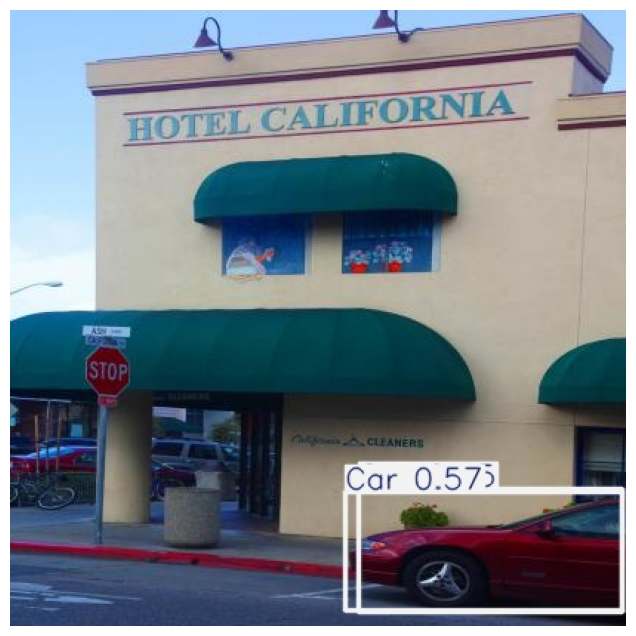

In [42]:
img_path = '/kaggle/working/runs/detect/predict/3429c6851095a4c3_jpg.rf.2921b5c17bda3bda8b69e0f8b5e44894.jpg'
img = plt.imread(img_path)

plt.figure(figsize=(10, 8))
plt.imshow(img)
plt.axis(False)
plt.show()

### Predict Videos

In [43]:
!yolo task=detect mode=predict model=/kaggle/working/runs/detect/train/weights/best.pt source='/kaggle/input/input-video/traffic_input2.mp4'

Ultralytics 8.3.152 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15095MiB)
YOLOv10n summary (fused): 102 layers, 2,266,143 parameters, 0 gradients, 6.5 GFLOPs

video 1/1 (frame 1/1275) /kaggle/input/input-video/traffic_input2.mp4: 384x640 1 Ambulance, 1 Bus, 1 Car, 64.9ms
video 1/1 (frame 2/1275) /kaggle/input/input-video/traffic_input2.mp4: 384x640 1 Ambulance, 1 Bus, 8.1ms
video 1/1 (frame 3/1275) /kaggle/input/input-video/traffic_input2.mp4: 384x640 1 Ambulance, 1 Bus, 1 Car, 8.5ms
video 1/1 (frame 4/1275) /kaggle/input/input-video/traffic_input2.mp4: 384x640 1 Ambulance, 1 Bus, 1 Car, 10.4ms
video 1/1 (frame 5/1275) /kaggle/input/input-video/traffic_input2.mp4: 384x640 (no detections), 7.6ms
video 1/1 (frame 6/1275) /kaggle/input/input-video/traffic_input2.mp4: 384x640 (no detections), 7.5ms
video 1/1 (frame 7/1275) /kaggle/input/input-video/traffic_input2.mp4: 384x640 1 Car, 7.4ms
video 1/1 (frame 8/1275) /kaggle/input/input-video/traffic_input2.mp4: 384x640 3 Cars, 7.3ms
video 

### Define helper function to display videos

In [44]:
import io 
from IPython.display import HTML
from base64 import b64encode
def show_video(file_name, width=640):
  # show resulting deepsort video
  mp4 = open(file_name,'rb').read()
  data_url = "data:video/mp4;base64," + b64encode(mp4).decode()
  return HTML("""
  <video width="{0}" controls>
        <source src="{1}" type="video/mp4">
  </video>
  """.format(width, data_url))

### Convert resulting video from avi to mp4 file format

In [ ]:
# Convert avi to mp4
!ffmpeg -y -loglevel panic -i /kaggle/working/runs/detect/predict3/Input.avi output.mp4

# output object tracking video
path_output = "/kaggle/working/runs/detect/predict3/output.mp4"
show_video(path_output, width=960)